In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping

from IPython import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
plt.gray()

<Figure size 432x288 with 0 Axes>

In [2]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

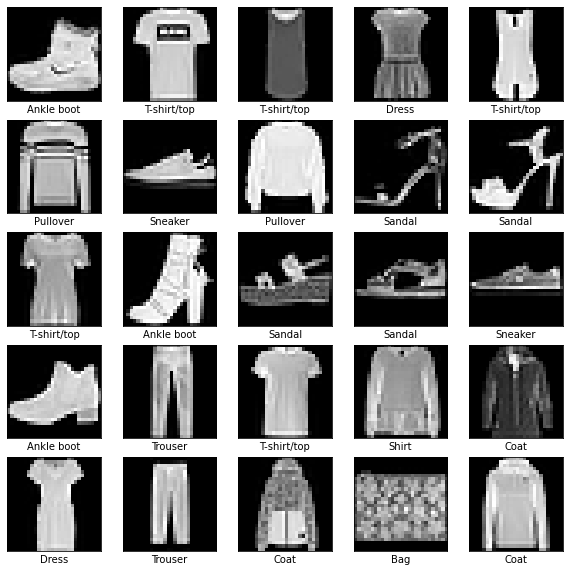

In [4]:
import math

def plot_data(num_images, images, labels):
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28))
      plt.xlabel(class_names[labels[i]])      
  plt.show()

plot_data(25, train_images, train_labels)


STAGE 1: Auto-encoders

Build the Encoder

In [5]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = layers.MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = layers.MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = layers.MaxPool2D( (2, 2), padding='same')(encoded_layer3)

Build the Decoder

In [6]:
#decoding architecture
decoded_layer1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = layers.UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = layers.UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = layers.Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = layers.UpSampling2D((2, 2))(decoded_layer3)
#output layer
output_layer   = layers.Conv2D(1, (3, 3), padding='same')(decoded_layer3)

Build the Model

In [7]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [8]:
history_loss = []
history_val_loss = []

def add_history(history):
  history_loss.append(history.history["loss"])
  history_val_loss.append(history.history["val_loss"])

def reset_history():
  global history_loss
  global history_val_loss
  history_loss = []
  history_val_loss = []
  return []

def plot_results(num_images, images, labels, history):
  add_history(history)
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28))
      plt.xlabel(class_names[labels[i]])      
  plt.show()
  plt.plot(history_loss, label='loss')
  plt.plot(history_val_loss, label='val_loss')
  plt.legend()
  plt.show()  

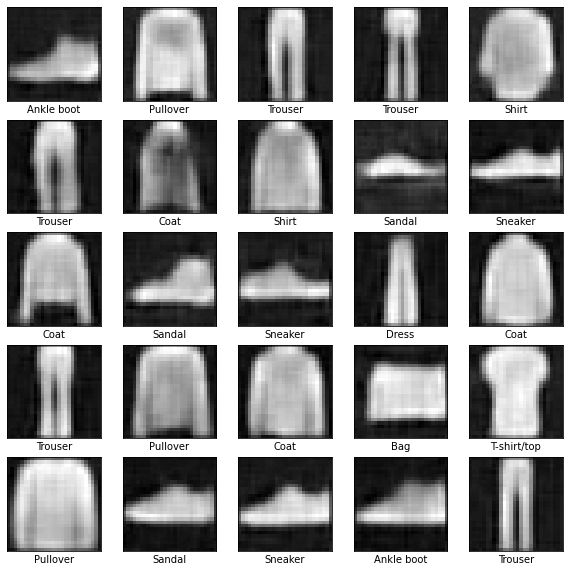

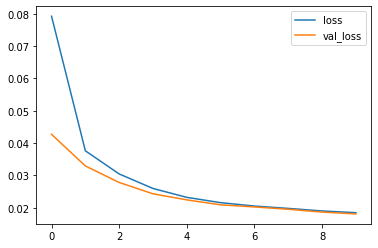

In [9]:
EPOCHS = 10
history = reset_history()

for i in range(EPOCHS):
  history = model.fit(train_images, train_images, epochs=1, batch_size=2048, validation_data=(test_images, test_images))
  pred_images = model.predict(test_images[:25])
  clear_output()
  plot_results(25, pred_images[:25], test_labels[:25], history)

# Improving the Autoendoer

In [10]:
# input layer
inputs = layers.Input(shape=(28, 28 ,1))

x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPool2D()(x)

# Decoder
x = layers.Conv2DTranspose(64, 3,activation='relu',strides=(2,2))(encoded)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2DTranspose(32, 3, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
decoded = layers.Conv2DTranspose(1, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

# compile the model
model = Model(inputs, decoded)
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 32)        128 

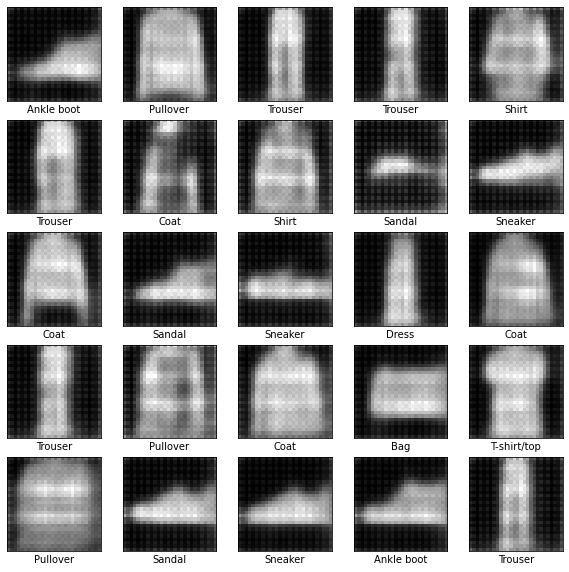

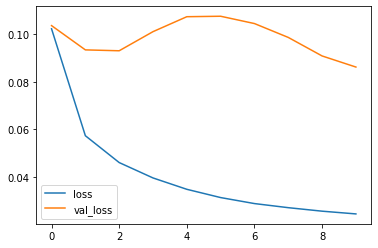

In [11]:
EPOCHS = 10
history = reset_history()

for i in range(EPOCHS):
  history = model.fit(train_images, train_images, epochs=1, batch_size=2048, validation_data=(test_images, test_images))
  pred_images = model.predict(test_images[:25])
  clear_output()
  plot_results(25, pred_images[:25], test_labels[:25], history)

In [12]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
#x = layers.BatchNormalization()(x)
x = layers.MaxPool2D( (2, 2), padding='same')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPool2D( (2, 2), padding='same')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPool2D( (2, 2), padding='same')(x)
#x = layers.Dropout(0.5)(x)

#decoding architecture
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = layers.Dropout(0.5)(x)
x = layers.UpSampling2D((2, 2))(x)
#x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.Dropout(0.5)(x)
x = layers.UpSampling2D((2, 2))(x)
#x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.UpSampling2D((2, 2))(x)
#x = layers.BatchNormalization()(x)
#output layer
output_layer   = layers.Conv2D(1, (3, 3), padding='same')(x)

# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 16)          4624

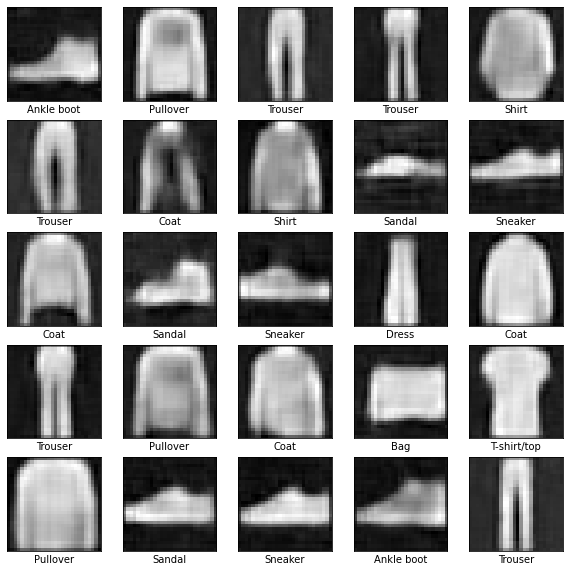

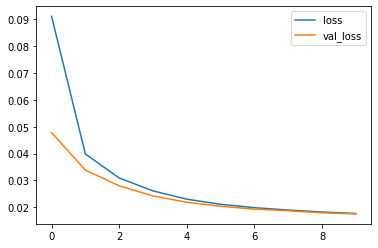

In [13]:
EPOCHS = 10
history = reset_history()

for i in range(EPOCHS):
  history = model.fit(train_images, train_images, epochs=1, batch_size=2048, validation_data=(test_images, test_images))
  pred_images = model.predict(test_images[:25])
  clear_output()
  plot_results(25, pred_images[:25], test_labels[:25], history)